In [1]:
import tensorflow as tf
import numpy as np

# 导入TF库的相关模块
from tensorflow.keras import layers, Sequential, regularizers

# 导入scikit-learn库相关模块
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

# 导入绘图库
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# 09. 过拟合
机器学习的主要目的是从训练集上学习到数据的真实模型，从而能够在未见过的测试集上也能够表现良好，我们把这种能力叫做`泛化能力`。通常来说，训练集和测试集都采样自某个相同的数据分布$p(x)$。采样到的样本是相互独立的，但是又来自于相同的分布，我们把这种假设叫做`独立同分布假设`(Independent Identical Distribution assumption，简称`i.i.d.`)。

模型的表达能力，也称之为模型的`容量`(Capacity)。当模型的表达能力偏弱时，比如单一线性层，它只能学习到线性模型，无法良好地逼近非线性模型；但模型的表达能力过强时，它就有可能把训练集的噪声模态也学到，导致在测试集上面表现不佳的现象(泛化能力偏弱)。因此针对不同的任务，设计合适容量的模型算法才能取得较好的泛化性能。

## 9.1 模型的容量
通俗地讲，模型的容量或表达能力，是指模型拟合复杂函数的能力。

一种体现模型容量的指标为模型的`假设空间`(Hypothesis Space)大小，即模型可以表示的函数集的大小。假设空间越大越完备，从假设空间中搜索出逼近真实模型的函数也就越有可能；反之，如果假设空间非常受限，就很难从中找到逼近真实模型的函数。

考虑采样自真实分布：
+ $p_{data} = {(x,y)|y = \sin(x), x \in [−5,5]}$

的数据集，从真实分布中采样少量样本点构成训练集，其中包含了观测误差$\epsilon$，如`图9.1`中的小圆点。

<img src="images/09_01.png" style="width:600px;"/>

+ 如果只搜索所有一次多项式的模型空间，$y = ax$，如`图9.1`中一次多项式的直线所示，则很难找到一条直线较好地逼近真实数据的分布
+ 稍微增大假设空间，令假设空间为所有的三次多项式函数，即$y = ax^3 + bx^2 + cx$，很明显此假设空间明显大于一次多项式的假设空间，我们可以找到一条曲线，它比一次多项式模型更好地反映了数据的关系，但是仍然不够好
+ 再次增大假设空间，使得可以搜索的函数为五次多项式，即$y = ax^5 + bx^4 + cx^3 + dx^2 + ex$，在此假设空间中，可以搜索到一个较好的函数
+ 再次增加假设空间后，如`图9.1`中7、9、11、13、15、17次多项式曲线所示，函数的假设空间越大，就越有可能找到一个函数更好地逼近真实分布的函数模型

但是过大的假设空间无疑会增加搜索难度和计算代价。实际上，在有限的计算资源的约束下，较大的假设空间并不一定能搜索出更好的函数模型。同时由于观测误差的存在，较大的假设空间中可能包含了大量表达能力过强的函数，能够将训练样本的观测误差也学习进来，从而伤害了模型的泛化能力。挑选合适容量的学习模型是一个很大的难题。


## 9.2 过拟合与欠拟合
当模型的容量过大时，网络模型除了学习到训练集数据的模态之外，还把额外的观测误差也学习进来，导致学习的模型在训练集上面表现较好，但是在未见的样本上表现不佳，也就是模型泛化能力偏弱，我们把这种现象叫作`过拟合`(Overfitting)；当模型的容量过小时，模型不能够很好地学习到训练集数据的模态，导致训练集上表现不佳，同时在未见的样本上表现也不佳，我们把这种现象叫作`欠拟合`(Underfitting)。

<img src="images/09_02.png" style="width:400px;"/>

`图9.3`绘制了某种数据的分布图，大致推测可能属于某二次多项式分布。如果我们用简单的线性函数去学习时，会发现模型在训练集和测试集表现都不理 想的现象，这种现象叫做`欠拟合`；但如果用较复杂的函数模型去学习时，有可能学习到的函数会过度地“拟合”训练集样本，从而导致在测试集上表现不佳，这种现象叫做`过拟合`。只有学习的模型和真实模型容量大致匹配时，模型才能具有较好地泛化能力。

<img src="images/09_03.png" style="width:550px;"/>

那么如何去选择模型的容量？统计学习理论给我们提供了一些思路，其中`VC维度`(Vapnik-Chervonenkis维度)是一个应用比较广泛的度量函数容量的方法。尽管这些方法给机器学习提供了一定程度的理论保证，但是这些方法却很少应用到深度学习中去，一部分原因是神经网络过于复杂，很难去确定网络结构背后的数学模型的`VC维度`。

尽管统计学习理论很难给出神经网络所需要的最小容量，但是却可以根据`奥卡姆剃刀`(Occam’s razor)原理来指导神经网络的设计和训练。

现代深度神经网络中过拟合现象非常容易出现，主要是因为神经网络的表达能力非常强，训练集样本数不够，很容易就出现了神经网络的容量偏大的现象。那么如何有效检测并减少过拟合现象呢？

## 9.3 数据集划分
我们介绍了数据集需要划分为`训练集`和`测试集`，但是为了挑选模型超参数和检测过拟合现象，一般需要将原来的`训练集`再次切分为新的`训练集`和`验证集`，即数据集需要切分为`训练集`、`验证集`和`测试集`3个子集。

一般把对训练集中的一个`Batch`运算更新一次叫做一个`Step`，对训练集的所有样本循环迭代一次叫做一个`Epoch`。验证集可以在数次`Step`或数次`Epoch`后使用，计算模型的验证性能。验证的步骤过于频繁，能够精准地观测模型的训练状况，但是也会引入额外的计算代价，一般建议几个`Epoch`后进行一次验证运算。

通过观测训练准确率和验证准确率可以大致推断模型是否出现过拟合和欠拟合。如果模型的训练误差较低，训练准确率较高，但是验证误差较高，验证准确率较低，那么可能出现了过拟合现象。如果训练集和验证集上面的误差都较高，准确率较低，那么可能出现了欠拟合现象。

当观测到过拟合现象时，可以从新设计网络模型的容量，如降低网络的层数、降低网络的参数量、添加正则化手段、添加假设空间的约束等，使得模型的实际容量降低，从而减轻或解决过拟合现象；当观测到欠拟合现象时，可以尝试增大网络的容量，如加深网络的层数、增加网络的参数量，尝试更复杂的网络结构。

## 9.4 模型设计
通过验证集可以判断网络模型是否过拟合或者欠拟合，从而为调整网络模型的容量提供判断依据。对于神经网络来说，网络的层数和参数量是网络容量很重要的参考指标，通过减少网络的层数，并减少每层中网络参数量的规模，可以有效降低网络的容量。反之，如果发现模型欠拟合，需要增大网络的容量，可以通过增加层数，增大每层的参数量等方式实现。

为了演示网络层数对网络容量的影响，我们可视化了一个分类任务的`决策边界`(Decision boundary)。`图9.12`、`图9.13`、`图9.14`、`图9.15`分别演示在不同的网络层数下训练二分类任务的决策边界图，其中红色矩形块和蓝色圆形块分别代表了训练集上的两类样本，保持其它超参数一致，仅调整网络的层数，训练获得样本上的分类效果。

<img src="images/09_15.png" style="width:600px;"/>

## 9.5 正则化
通过设计不同层数、大小的网络模型可以为优化算法提供初始的函数假设空间，但是模型的实际容量可以随着网络参数的优化更新而产生变化。以多项式函数模型为例：
+ $y = \beta_0 + \beta_1x + \beta_2x^2 + \beta_3x^3 + \dots + \beta_nx^n + \epsilon$

上述模型的容量可以通过$n$简单衡量。在训练的过程中，如果网络参数$\beta_{k+1},\dots,\beta_{n}$均为0，那么网络的实际容量退化到$k$次多项式的函数容量。因此，通过限制网络参数的稀疏性，可以来约束网络的实际容量。

这种约束一般通过在损失函数上添加额外的参数稀疏性惩罚项实现，在未加约束之前的优化目标是
+ $\min\mathcal{L}(f_{\theta}(x),y), \ (x,y) \in \mathbb{D}^{\mathrm{train}}$

对模型的参数添加额外的约束后，优化的目标变为
+ $\min\mathcal{L}(f_{\theta}(x),y) + \lambda\cdot\Omega(\theta), \ (x,y) \in \mathbb{D}^{\mathrm{train}}$

其中$\Omega(\theta)$表示对网络参数$\theta$的稀疏性约束函数。一般地，参数$\theta$的稀疏性约束通过约束参数$\theta$的$L$范数实现，即
+ $\Omega(\theta) = \displaystyle\sum_{\theta_i}\lVert\theta_i\rVert_l$

其中$\lVert\theta_i\rVert_l$表示参数$\theta_i$的$l$范数。

新的优化目标除了要最小化原来的损失函数$\mathcal{L}(x,y)$之外，还需要约束网络参数的稀疏性$\Omega(\theta)$，优化算法会在降低$\mathcal{L}(x,y)$的同时，尽可能地迫使网络参数$\theta_i$变得稀疏，它们之间的权重关系通过超参数$\lambda$来平衡。较大的$\lambda$意味着网络的稀疏性更重要；较小的$\lambda$则意味着网络的训练误差更重要。通过选择合适的$\lambda$超参数，可以获得较好的训练性能，同时保证网络的稀疏性，从而获得不错的泛化能力。

常用的正则化方式有$L0、L1、L2$正则化。

### 9.5.1 L0正则化
$L0$正则化是指采用$L0$范数作为稀疏性惩罚项$\Omega(\theta)$的正则化计算方式，即
+ $\Omega(\theta) = \displaystyle\sum_{\theta_i}\lVert\theta_i\rVert_0$

其中$L0$范数$\lVert\theta_i\rVert_0$定义为$\theta_i$中非零元素的个数。通过约束$\displaystyle\sum_{\theta_i}\lVert\theta_i\rVert_0$的大小可以迫使网络中的连接权值大部分为0，从而降低网络的实际参数量和网络容量。但是由于$L0$范数$\lVert\theta_i\rVert_0$并不可导，不能利用梯度下降算法进行优化，在神经网络中使用的并不多。

### 9.5.2 L1正则化
采用$L1$范数作为稀疏性惩罚项$\Omega(\theta)$的正则化计算方式叫作$L1$正则化，即
+ $\Omega(\theta) = \displaystyle\sum_{\theta_i}\lVert\theta_i\rVert_1$

其中$L1$范数$\lVert\theta_i\rVert_1$定义为张量$\theta_i$中所有元素的绝对值之和。$L1$正则化也叫`Lasso Regularization`，它是连续可导的，在神经网络中使用广泛。

$L1$正则化可以实现如下：

In [2]:
# 创建网络参数 w1,w2
w1 = tf.random.normal([4,3])
w2 = tf.random.normal([4,2])

# 计算 L1 正则化项
loss_reg = tf.reduce_sum(tf.math.abs(w1)) + tf.reduce_sum(tf.math.abs(w2))
loss_reg

<tf.Tensor: shape=(), dtype=float32, numpy=15.015711>

### 9.5.3 L2正则化
采用$L2$范数作为稀疏性惩罚项$\Omega(\theta)$的正则化计算方式叫做$L2$正则化，即
+ $\Omega(\theta) = \displaystyle\sum_{\theta_i}\lVert\theta_i\rVert_2$

其中$L2$范数$\lVert\theta_i\rVert_2$定义为张量$\theta_i$中所有元素的平方和。$L2$正则化也叫`Ridge Regularization`，它和$L1$正则化一样，也是连续可导的，在神经网络中使用广泛。

$L2$正则化项实现如下：

In [3]:
# 创建网络参数 w1,w2
w1 = tf.random.normal([4,3])
w2 = tf.random.normal([4,2])

# 计算 L2 正则化项
loss_reg = tf.reduce_sum(tf.square(w1)) + tf.reduce_sum(tf.square(w2))

### 9.5.4 正则化效果
继续以月牙形的二分类数据为例。在维持网络结构等其它超参数不变的条件下，在损失函数上添加$L2$正则化项，并通过改变不同的正则化超参数$\lambda$来获得不同程度的正则化效果。

在训练了500个`Epoch`后，我们获得学习模型的分类决策边界如图所示：

<img src="images/09_19.png" style="width:600px;"/>

可以看到，随着正则化系数$\lambda$的增加，网络对参数稀疏性的惩罚变大，从而迫使优化算法搜索让网络容量更小的模型。

在不同的正则化系数$\lambda$下，我们统计了网络中每个连接权值的数值范围。考虑网络的第2层的权值矩阵$W$，其`shape`为`[256,256]`，即将输入长度为256的向量转换为256的输出向量。从全连接层权值连接的角度来看，$W$一共包含了$256 \times 256$根连接线的权值，我们将它对应到`图9.20`、`图9.21`、`图9.22`、`图9.23`中的$X-Y$网格中，其中$X$轴的范围为`[0,255]`，$Y$轴的范围为`[0,255]`，$X-Y$网格的所有整数点分别代表了`shape`为`[256,256]`的权值张量$W$的每个位置，每个网格点绘制出当前连接上的权值。从图中可以看到，添加了不同程度的正则化约束对网络权值的影响。

<img src="images/09_23.png" style="width:600px;"/>

在$\lambda = 0.00001$时，正则化的作用比较微弱，网络中权值数值相对较大，分布在`[−1.6088,1.1599]`区间；在添加较强稀疏性约束$\lambda = 0.13$后，网络权值数值约束在`[−0.1104,0.0785]`较小范围中，具体的权值范围如`表格9.1`所示，同时也可以观察到正则化后权值的稀疏性变化。

<img src="images/t_09_01.png" style="width:400px;"/>

## 9.6 Dropout
2012年，`Hinton`等人在其论文`《Improving neural networks by preventing co-adaptation of feature detectors》`中使用了`Dropout`方法来提高模型性能。`Dropout`通过随机断开神经网络的连接，减少每次训练时实际参与计算的模型的参数量；但是在测试时，`Dropout`会恢复所有的连接，保证模型测试时获得最好的性能。

在`TensorFlow`中，可以通过`tf.nn.dropout(x, rate)`函数实现某条连接的`Dropout`功能， 其中`rate`参数设置断开的概率值$p$：

```python
# 添加dropout操作，断开概率为0.5
x = tf.nn.dropout(x, rate=0.5)
```

也可以将`Dropout`作为一个网络层使用：

```python
# 添加Dropout层，断开概率为0.5
model.add(layers.Dropout(rate=0.5))
```

为了验证`Dropout`层对网络训练的影响，我们在维持网络层数等超参数不变的条件下，通过在5层的全连接层中间隔插入不同数量的`Dropout`层来观测`Dropout`对网络训练的影响。

<img src="images/09_28.png" style="width:600px;"/>

## 9.7 数据增强
除了上述介绍的方式可以有效检测和抑制过拟合现象之外，增加数据集规模是解决过拟合最重要的途径。但是收集样本数据和标签往往是代价昂贵的，在有限的数据集上，通过数据增强技术可以增加训练的样本数量，获得一定程度上的性能提升。

`数据增强`(Data Augmentation)是指在维持样本标签不变的条件下，根据先验知识改变样本的特征，使得新产生的样本也符合或者近似符合数据的真实分布。

<img src="images/09_29.png" style="width:250px;"/>

`tf.image`子模块提供了常用图片的处理函数。通过`tf.image.resize`函数可以实现图片的缩放功能：

```python
def preprocess(x,y):
    # 预处理函数
    # x: 图片的路径，y：图片的数字编码
    x = tf.io.read_file(x)
    x = tf.image.decode_jpeg(x, channels=3) # RGBA
    # 图片缩放到 244x244 大小，这个大小根据网络设定自行调整
    x = tf.image.resize(x, [244, 244])
```

### 9.7.1 旋转
旋转图片将原图进行一定角度的旋转运算，可以获得不同角度的新图片，这些图片的标签信息维持不变。通过`tf.image.rot90(x, k=1)`可以实现图片按逆时针方式旋转$k$个90度。

<img src="images/09_30.png" style="width:200px;"/>

```python
# 图片逆时针旋转180度
x = tf.image.rot90(x,2)
```

### 9.7.2 翻转
图片的翻转分为沿水平轴翻转和竖直轴翻转，可以通过`tf.image.random_flip_left_right`和`tf.image.random_flip_up_down`实现：

```python
# 随机水平翻转
x = tf.image.random_flip_left_right(x)
# 随机竖直翻转
x = tf.image.random_flip_up_down(x)
```

<img src="images/09_32.png" style="width:450px;"/>

### 9.7.3 裁剪
通过在原图的左右或者上下方向去掉部分边缘像素，可以保持图片主体不变，同时获得新的图片样本。

在实际裁剪时，一般先将图片缩放到略大于网络输入尺寸的大小，再裁剪到合适大小：

```python
# 图片先缩放到稍大尺寸
x = tf.image.resize(x, [244, 244])
# 再随机裁剪到合适尺寸
x = tf.image.random_crop(x, [224,224,3])
```

<img src="images/09_35.png" style="width:500px;"/>

### 9.7.4 生成数据
通过生成模型在原有数据上进行训练，学习到真实数据的分布，从而利用生成模型获得新的样本，这种方式也可以在一定程度上提升网络性能。如通过`条件生成对抗网络`(Conditional GAN,简称CGAN)可以生成带标签的样本数据。

### 9.7.5 其它方式
除了上述数据增强方式以外，还可以根据先验知识，在不改变图片标签信息的条件下，任意变换图片数据，获得新的图片。

<img src="images/09_36.png" style="width:500px;"/>

## 9.8 过拟合问题实战
我们使用月牙形状的二分类数据集的对过拟合与欠拟合模型进行完整的实战。

### 9.8.1 构建数据集

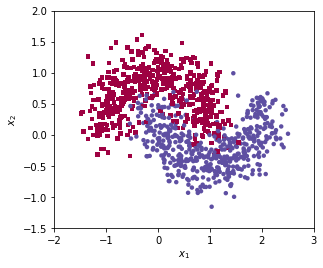

In [4]:
# 全局变量
N_EPOCHS = 500

def load_dataset():
    # 采样点数
    N_SAMPLES = 1000
    # 测试数量比率
    TEST_SIZE = None
    # 从 moon 分布中随机采样 1000 个点，并切分为训练集-测试集
    X, y = make_moons(n_samples=N_SAMPLES, noise=0.25, random_state=100)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)
    return X, y, X_train, X_test, y_train, y_test

def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=False, output_dir=None):
    axes = plt.gca()
    axes.set_xlim([-2, 3])
    axes.set_ylim([-1.5, 2])
    axes.set(xlabel="$x_1$", ylabel="$x_2$")
    plt.title(plot_name, fontsize=20, fontproperties='SimHei')
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if XX is not None and YY is not None and preds is not None:
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha=0.08, cmap=plt.cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    # 绘制散点图，根据标签区分颜色m=markers
    markers = ['o' if i == 1 else 's' for i in y.ravel()]
    mscatter(X[:, 0], X[:, 1], c=y.ravel(), s=20, cmap=plt.cm.Spectral, edgecolors='none', m=markers, ax=axes)
    # 保存矢量图
    plt.show()

def mscatter(x, y, ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    if not ax: ax = plt.gca()
    sc = ax.scatter(x, y, **kw)
    if (m is not None) and (len(m) == len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

# 从moon分布中随机采样1000个点，并切分为训练集-测试集
X, y, X_train, X_test, y_train, y_test = load_dataset()
# 绘制图形
make_plot(X, y, None)

### 9.8.2 网络层数的影响
为了探讨不同的网络深度下的过拟合程度，我们共进行了5次训练实验。在$n \in [0,4]$时，构建网络层数为$n+2$层的全连接层网络，并通过`Adam`优化器训练500个Epoch，获得网络在训练集上的分隔曲线：

findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.


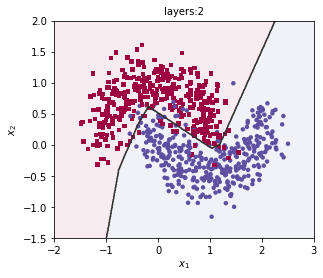

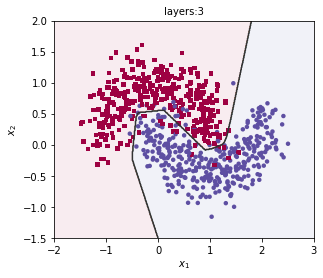

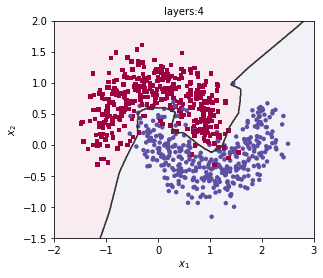

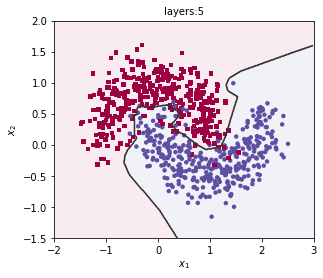

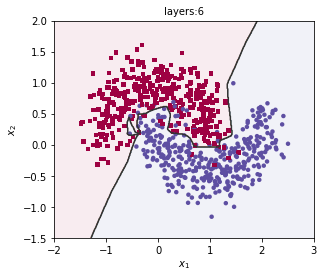

In [5]:
def network_layers_influence(X_train, y_train):
    for n in range(5):
        model = Sequential()
        # 创建第一层
        model.add(layers.Dense(8, input_dim=2, activation='relu'))
        # 添加n层，共n+2层
        for _ in range(n):
            model.add(layers.Dense(32, activation='relu'))
        # 创建最末层
        model.add(layers.Dense(1, activation='sigmoid'))
        # 模型装配与训练
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=N_EPOCHS, verbose=0)
        # 绘制不同层数的网络决策边界曲线
        # 可视化的x坐标范围为[-2, 3]
        xx = np.arange(-2, 3, 0.01)
        # 可视化的 y 坐标范围为[-1.5, 2]
        yy = np.arange(-1.5, 2, 0.01)
        # 生成 x-y 平面采样网格点，方便可视化
        XX, YY = np.meshgrid(xx, yy)
        preds = model.predict_classes(np.c_[XX.ravel(), YY.ravel()])
        title = "layers:{0}".format(2 + n)
        file = "capacity_%i.png" % (2 + n)
        make_plot(X_train, y_train, title, file, XX, YY, preds)

network_layers_influence(X_train, y_train)

### 9.8.3 Dropout 的影响
我们进行5次实验，每次实验使用7层的全连接层网络进行训练，但是在全连接层中间隔插入0~4个`Dropout`层，并通过`Adam`优化器训练`500`个 Epoch。

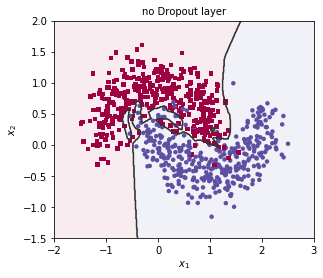

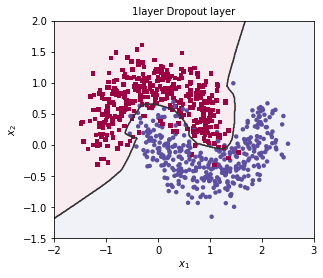

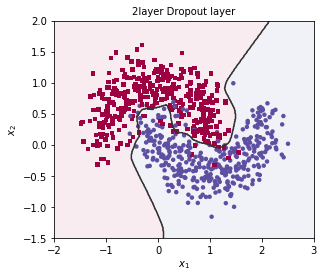

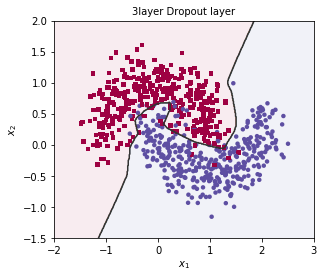

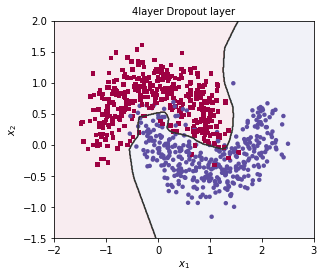

In [6]:
def dropout_influence(X_train, y_train):
    for n in range(5):
        model = Sequential()
        # 创建第一层
        model.add(layers.Dense(8, input_dim=2, activation='relu'))
        counter = 0
        # 网络层数固定为5
        for _ in range(5):
            model.add(layers.Dense(64, activation='relu'))
            # 添加n个Dropout层(add by alex: 原文代码有错)
            if counter < n:
                counter += 1
                model.add(layers.Dropout(rate=0.5))
        # 输出层
        model.add(layers.Dense(1, activation='sigmoid'))
        # 模型装配
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        # 训练
        model.fit(X_train, y_train, epochs=N_EPOCHS, verbose=0)
        # 绘制不同Dropout层数的决策边界曲线
        # 可视化的x坐标范围为[-2, 3]
        xx = np.arange(-2, 3, 0.01)
        # 可视化的y坐标范围为[-1.5, 2]
        yy = np.arange(-1.5, 2, 0.01)
        # 生成x-y平面采样网格点，方便可视化
        XX, YY = np.meshgrid(xx, yy)
        preds = model.predict_classes(np.c_[XX.ravel(), YY.ravel()])
        title = "no Dropout layer" if n == 0 else "{0}layer Dropout layer".format(n)
        file = "Dropout_%i.png" % n
        make_plot(X_train, y_train, title, file, XX, YY, preds)

dropout_influence(X_train, y_train)

### 9.8.4 正则化的影响
为了探讨正则化系数$\lambda$对网络模型训练的影响，我们采用$L2$正则化方式，构建了5层的神经网络，其中第2、3、4层神经网络层的权值张量$W$均添加$L2$正则化约束项。

/home/alex/3rd/py-venv/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 65306 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/alex/3rd/py-venv/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 65306 missing from current font.
  font.set_text(s, 0, flags=flags)


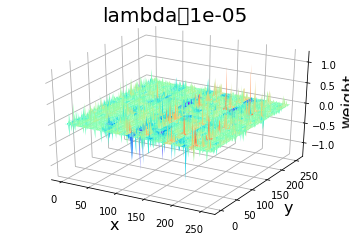

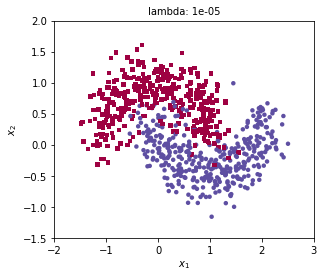

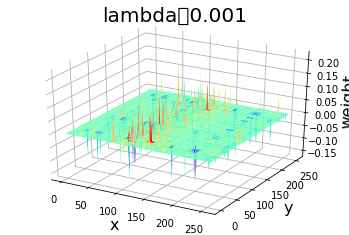

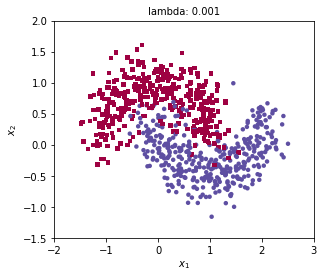

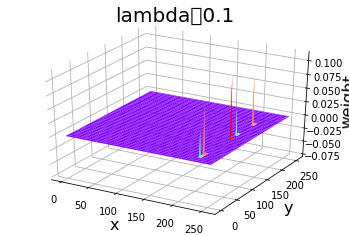

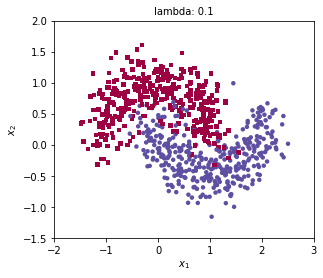

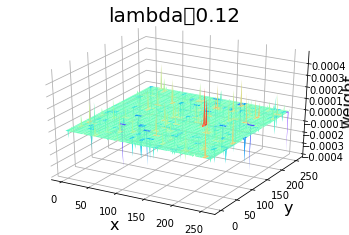

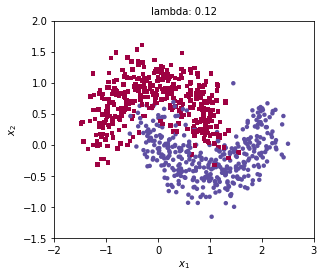

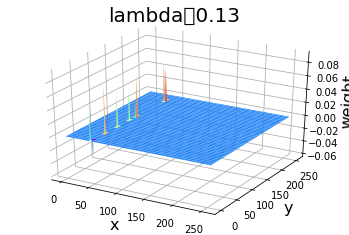

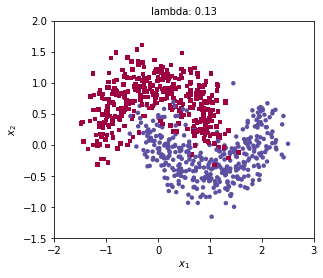

In [7]:
def build_model_with_regularization(_lambda):
    # 创建带正则化项的神经网络
    model = Sequential()
    model.add(layers.Dense(8, input_dim=2, activation='relu'))  # 不带正则化项
    # 2-4层均是带 L2 正则化项
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(_lambda)))
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(_lambda)))
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(_lambda)))
    # 输出层
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  # 模型装配
    return model

def plot_weights_matrix(model, layer_index, plot_name, file_name=None, output_dir=None):
    # 绘制权值范围函数
    # 提取指定层的权值矩阵
    weights = model.layers[layer_index].get_weights()[0]
    shape = weights.shape
    # 生成和权值矩阵等大小的网格坐标
    X = np.array(range(shape[1]))
    Y = np.array(range(shape[0]))
    X, Y = np.meshgrid(X, Y)
    # 绘制3D图
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    plt.title(plot_name, fontsize=20)
    # 绘制权值矩阵范围
    ax.plot_surface(X, Y, weights, cmap=plt.get_cmap('rainbow'), linewidth=0)
    # 设置坐标轴名
    ax.set_xlabel('x', fontsize=16, rotation=0)
    ax.set_ylabel('y', fontsize=16, rotation=0)
    ax.set_zlabel('weight', fontsize=16, rotation=90)
    # 保存矩阵范围图
    plt.show()

def regularizers_influence(X_train, y_train):
    for _lambda in [1e-5, 1e-3, 1e-1, 0.12, 0.13]:  # 设置不同的正则化系数
        # 创建带正则化项的模型
        model = build_model_with_regularization(_lambda)
        # 模型训练
        model.fit(X_train, y_train, epochs=N_EPOCHS, verbose=0)
        # 绘制权值范围
        layer_index = 2
        plot_title = "lambda：{}".format(_lambda)
        # 绘制网络权值范围图
        plot_weights_matrix(model, layer_index, plot_title)
        # 绘制不同正则化系数的决策边界线
        # 可视化的 x 坐标范围为[-2, 3]
        xx = np.arange(-2, 3, 0.01)
        # 可视化的 y 坐标范围为[-1.5, 2]
        yy = np.arange(-1.5, 2, 0.01)
        # 生成 x-y 平面采样网格点，方便可视化
        XX, YY = np.meshgrid(xx, yy)
        preds = model.predict_classes(np.c_[XX.ravel(), YY.ravel()])
        title = "lambda: {}".format(_lambda)
        make_plot(X_train, y_train, title, XX, YY, preds)

regularizers_influence(X_train, y_train)